In [4]:
# import talib
import matplotlib
from matplotlib import cm
from scipy.stats import kstest
from matplotlib import pyplot as plt
from hmmlearn.hmm import GaussianHMM, GMMHMM
from matplotlib.dates import YearLocator, MonthLocator
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from node2vec import Node2Vec


import warnings
import numpy as np
import pickle
from scipy.sparse import csr_matrix, triu, tril
import pandas as pd
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

# 0. Load data
Graph creation

In [ ]:
G = nx.Graph()
with open("training.txt", "r") as f: # f is a local variable
    for line in f:
        line = line.split()
        G.add_nodes_from([line[0],line[1]]) # don't forget the node without edge
        #print(line)
        if line[2] == '1':
            G.add_edge(line[0], line[1])

# Generate walks
node2vec = Node2Vec(G, dimensions=6, walk_length=3, num_walks=20)
print('node2vec succeed' )
# Learn embeddings 
model = node2vec.fit(window=5, min_count=1)
print('model built')


In [105]:
# save pkl file of graph 
model_df = pd.DataFrame({'model':[model],'G': [G]})
model_df.to_pickle('model_G_df_raw.pkl')

In [59]:
# model = pd.read_pickle('model_G_df_raw.pkl')['model'][0]
# model = pd.read_pickle('model_G_df_raw.pkl')['G'][0]

Feature extraction

In [67]:
D = []
with open("training.txt", "r") as f: 
    for line in f:
        line = line.split()
        D.append(line)


D_testing = []
with open("testing.txt", "r") as f: 
    for line in f:
        line = line.split()
        D_testing.append(line)    

In [68]:

D_train, D_test = train_test_split(D, test_size=0.3, random_state=171)        


file1 = open("train.txt","w")
file2 = open("test.txt","w")

for line in D_train:
    file1.write(line[0]+" "+line[1]+" "+line[2]+"\n")
for line in D_test:
    file2.write(line[0]+" "+line[1]+" "+line[2]+"\n")



In [69]:


# common neighbors
def CN(node1, node2):
    try:
        iter_CN = nx.common_neighbors(G,node1,node2) # an iterator
        cn = len(list(iter_CN))

    except:
        print("An exception occurred")
        cn = 0
        
    return cn

# Jaccard coefficient
def JC(node1, node2):
    
    coef = [[u, v, p]for u, v, p in nx.jaccard_coefficient(G, [(node1, node2)])][0]
    # return an iterator, coef = [(u,v,p)]
    
    return coef[2]

# adamic adar index
def AA(node1, node2):
    #print(coef) # ex ['7706', '690', 0.2211514277946646]
    coef = [[u, v, p]for u, v, p in nx.adamic_adar_index(G, [(node1, node2)])][0]
    # return an iterator, coef = [(u,v,p)]
    
    return coef[2]

#resource allocation
def RA(node1, node2):

    coef = [[u, v, p]for u, v, p in nx.resource_allocation_index(G, [(node1, node2)])][0]

    return coef[2]

#preferential attachment
def PA(node1, node2):

    return G.degree[node1]*G.degree[node2]

# ajusted rand
# general : #ARI = (RI - Expected_RI) / (max(RI) - Expected_RI), Given the contingency table
# see : https://davetang.org/muse/2017/09/21/adjusted-rand-index/
def AR(node1, node2): 

    num_nodes = G.number_of_nodes()

    a = CN(node1,node2)
    b = G.degree[node2] - a
    c = G.degree[node1] - a
    d = num_nodes  - b - c - a
    denominator = (a+b)*(b+d)+(a+c)*(c+d)
    if (denominator ==0):
        return 0
    else :
        return 2*(a*d-b*c)/denominator

# neighbourhood distance
def ND(node1, node2):
    UD = G.degree[node1]
    VD = G.degree[node2]

    if (UD*VD == 0) : # if UD =0. CN(node1,node2) ==0
        ND = 0
    else:
        ND = CN(node1,node2)/np.sqrt(UD*VD)

    return [ND,UD,VD]

# total neighbours
def TN(node1, node2):

    return G.degree[node1] + G.degree[node2] - CN(node1,node2)


In [70]:
text_matrix = np.load("text_matrix.npy")


In [71]:
def Data_dict(D) : 
    cn = []
    jc = []
    aa = []
    ra = []
    pa = []
    ar = []
    tn = []
    nd = []
    tfidf = []
    n2v = []
    label = []

    for line in D:
        node1 = int(line[0]); node2 = int(line[1])
        cn.append(CN(node1,node2))
        jc.append(JC(node1,node2))
        aa.append(AA(node1,node2))
        ra.append(RA(node1,node2))
        pa.append(PA(node1,node2))
        ar.append(AR(node1,node2))
        tn.append(TN(node1,node2))
        nd.append(ND(node1,node2)[0])
        tfidf.append(cosine_similarity(np.reshape(text_matrix[node1],(1, -1)) , np.reshape(text_matrix[node2],(1, -1)))[0][0])
        n2v.append(N2V(node1,node2))
        label.append(int(line[2]))

    return {'CN': cn, 'JC': jc, 'AA':aa, 'RA': ra,'PA': pa,'AR': ar, 'TN': tn,'ND': nd, 'TFIDF': tfidf, 'N2V': n2v, 'label': label}

In [72]:
def Data_dict_test(D) : 
    cn = []
    jc = []
    aa = []
    ra = []
    pa = []
    ar = []
    tn = []
    nd = []
    tfidf = []
    n2v = []

    for line in D:
        node1 = int(line[0]); node2 = int(line[1])
        cn.append(CN(node1,node2))
        jc.append(JC(node1,node2))
        aa.append(AA(node1,node2))
        ra.append(RA(node1,node2))
        pa.append(PA(node1,node2))
        ar.append(AR(node1,node2))
        tn.append(TN(node1,node2))
        nd.append(ND(node1,node2)[0])
        tfidf.append(cosine_similarity(np.reshape(text_matrix[node1],(1, -1)) , np.reshape(text_matrix[node2],(1, -1)))[0][0])
        n2v.append(N2V(node1,node2))

    return {'CN': cn, 'JC': jc, 'AA':aa, 'RA': ra,'PA': pa,'AR': ar, 'TN': tn,'ND': nd, 'TFIDF': tfidf, 'N2V': n2v}

In [73]:
def N2V(node1, node2):
    try:
        sim = model.similarity(str(node1), str(node2))
    except:
        print("An exception occurred")
        sim = 0
    return sim

## 0.3. Construct train & test data

### a. final model train data & pred data 

In [80]:
# data used for final model 
all_df = pd.DataFrame(Data_dict(D))
all_df.to_pickle('all.pkl')

In [81]:
# final prediction training data 
demand_df = pd.DataFrame(Data_dict_test(D_testing))
demand_df.to_pickle('final_pred.pkl')


In [82]:
X_all = all_df.loc[:, all_df.columns != 'label']
y_all = all_df['label'].tolist()

### b. tuning model train data & pred data 

In [83]:
# model train and test (splited from training.txt)
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

X_train = train.loc[:, train.columns != 'label']
y_train = train['label'].tolist()
X_test = test.loc[:, test.columns != 'label']
y_test = test['label'].tolist()

## 0.4. Evaluation 

In [205]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def eval_metric(preds, y_test):
    # X_test etc. are for evaluation...
    # total = len(y_test)
    # arr_y_test = y_test.to_numpy()
    # right = 0
    # for i in range(total):
    #     if (abs(preds[i]-arr_y_test[i])<0.5):
    #         right +=1

    # print('precision:',right/total)
    print('confusion matrix')
    print(confusion_matrix(y_test, preds))
    print('\n')
    print('summary')
    print(classification_report(y_test, preds))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=2)
    metrics.auc(fpr, tpr)



# 1. Models
## 1.1. XGBoost


In [208]:
import xgboost as xgb


xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                            max_depth = 5, alpha = 20, n_estimators = 10) 

xg_reg.fit(X_train, y_train)
xg_preds = (xg_reg.predict(X_test)>=0.5)*1
eval_metric(xg_preds, y_test)

confusion matrix
[[43615  7349]
 [ 9006 76170]]


summary
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     50964
           1       0.91      0.89      0.90     85176

    accuracy                           0.88    136140
   macro avg       0.87      0.88      0.87    136140
weighted avg       0.88      0.88      0.88    136140



Feature ranking:
1. feature TN (0.334493)
2. feature PA (0.178844)
3. feature RA (0.170084)
4. feature AA (0.131492)
5. feature AR (0.086963)
6. feature N2V (0.032990)
7. feature CN (0.032084)
8. feature TFIDF (0.015056)
9. feature ND (0.009525)
10. feature JC (0.008469)


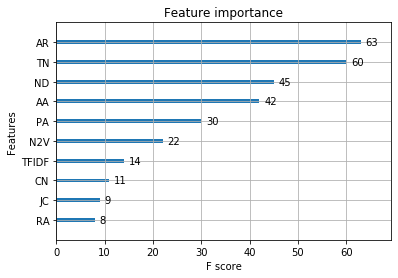

In [237]:
from xgboost import plot_importance
# plot feature importance


xg_importances = xg_reg.feature_importances_
xg_indices = np.argsort(xg_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns.tolist()[xg_indices[f]], xg_importances[xg_indices[f]]))


plot_importance(xg_reg)
plt.show()

In [245]:
# rebuild model by selecting the first three important features 
red_X_train = pd.DataFrame(X_train[['AR','TN','RA']])
red_X_test = pd.DataFrame(X_test[['AR','TN','RA']])

red_xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                            max_depth = 5, alpha = 20, n_estimators = 10) 

red_xg_reg.fit(red_X_train, y_train)
red_xg_preds = (red_xg_reg.predict(red_X_test)>=0.5)*1
eval_metric(red_xg_preds, y_test)

confusion matrix
[[40942 10022]
 [ 7364 77812]]


summary
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     50964
           1       0.89      0.91      0.90     85176

    accuracy                           0.87    136140
   macro avg       0.87      0.86      0.86    136140
weighted avg       0.87      0.87      0.87    136140



After droping the seemingly insignificant featrues the result does not improve but instead decrease a litte bit (f1 of class 0)

# 1.2. Hidden Markov model 
We first use unsupervised learning (HMM, GMM) and see if it could capture the hidden structure (if the feature engineering is done in an approach that we could capture the hidden representation of linkage between nodes)
## 1.2.1. HMM

In [87]:
nor_X_all = (X_all-X_all.mean())/X_all.std()
nor_X_all.describe()

,CN,JC,AA,RA,PA,AR,TN,ND,TFIDF,N2V
count,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05,4.537970e+05
mean,4.522670e-15,1.588645e-14,1.952964e-14,-2.507097e-16,1.051167e-16,-5.478410e-14,1.208714e-15,2.465395e-14,1.462040e-18,4.708277e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.055450e-01,-3.362450e-01,-2.559691e-01,-1.699658e-01,-1.382318e-01,-6.774711e-01,-3.278585e-01,-4.599180e-01,-2.386936e+00,-3.188615e+00
25%,-3.055450e-01,-3.362450e-01,-2.559691e-01,-1.699658e-01,-1.376334e-01,-3.848355e-01,-3.167623e-01,-4.599180e-01,-9.029028e-01,-7.259862e-01
50%,-3.055450e-01,-3.362450e-01,-2.559691e-01,-1.699658e-01,-1.328705e-01,-3.831588e-01,-2.828899e-01,-4.599180e-01,2.340813e-01,-2.537360e-02
75%,-9.107614e-02,-1.064535e-01,-7.522651e-02,-1.265768e-01,-9.639482e-02,-9.044465e-02,-1.608323e-01,2.127583e-02,9.680052e-01,6.781005e-01
max,7.786836e+01,1.490659e+01,8.593707e+01,9.157267e+01,2.059591e+02,1.018429e+01,6.698921e+00,9.401621e+00,1.175096e+00,2.065610e+00


since after normalization we get nan in tfidf w.l.o.g. we delete tfidf


In [88]:
hmm1 = GaussianHMM(n_components =2, n_iter = 10000).fit(nor_X_all)

hmm1_preds = hmm1.predict(nor_X_all)

confusion matrix
[[142537  27637]
 [ 81969 201654]]


summary
              precision    recall  f1-score   support

           0       0.63      0.84      0.72    170174
           1       0.88      0.71      0.79    283623

    accuracy                           0.76    453797
   macro avg       0.76      0.77      0.75    453797
weighted avg       0.79      0.76      0.76    453797



In [206]:
eval_metric(hmm1_preds, y_all)

confusion matrix
[[142537  27637]
 [ 81969 201654]]


summary
              precision    recall  f1-score   support

           0       0.63      0.84      0.72    170174
           1       0.88      0.71      0.79    283623

    accuracy                           0.76    453797
   macro avg       0.76      0.77      0.75    453797
weighted avg       0.79      0.76      0.76    453797



Since the performance is not that desried, we discard the HMM nad GMMHMM models.

## 1.3. Random forest 

In [94]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# random forest model 
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

eval_metric(rfc_predict, y_test)

confusion matrix
[[43608  7356]
 [11086 74090]]


summary
              precision    recall  f1-score   support

           0       0.80      0.86      0.83     50964
           1       0.91      0.87      0.89     85176

    accuracy                           0.86    136140
   macro avg       0.85      0.86      0.86    136140
weighted avg       0.87      0.86      0.87    136140



Feature importance

Feature ranking:
1. feature PA (0.341973)
2. feature TN (0.192370)
3. feature N2V (0.124351)
4. feature TFIDF (0.121954)
5. feature RA (0.064196)
6. feature AR (0.056206)
7. feature JC (0.045001)
8. feature AA (0.040873)
9. feature ND (0.009347)
10. feature CN (0.003730)


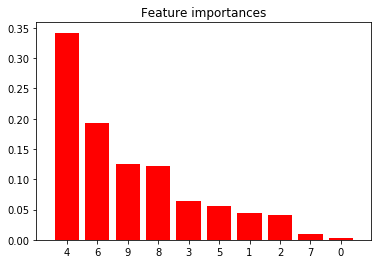

In [232]:
rfc_importances = rfc.feature_importances_
rfc_std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
rfc_indices = np.argsort(rfc_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns.tolist()[rfc_indices[f]], rfc_importances[rfc_indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), rfc_importances[rfc_indices],
       color="r", yerr=rfc_std[rfc_indices], align="center")
plt.xticks(range(X_train.shape[1]), rfc_indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [246]:
red_X_train = pd.DataFrame(X_train[['PA','TN','N2V','TFIDF']])
red_X_test = pd.DataFrame(X_test[['PA','TN','N2V','TFIDF']])
# random forest model with reduced features
red_rfc = RandomForestClassifier()
red_rfc.fit(red_X_train,y_train)
# predictions
red_rfc_predict = red_rfc.predict(red_X_test)

eval_metric(red_rfc_predict, y_test)

confusion matrix
[[43032  7932]
 [12293 72883]]


summary
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     50964
           1       0.90      0.86      0.88     85176

    accuracy                           0.85    136140
   macro avg       0.84      0.85      0.84    136140
weighted avg       0.86      0.85      0.85    136140



Similar results with the previous reduced feature model 

## 1.4. KNN


In [133]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

eval_metric(knn_pred, y_test)

confusion matrix
[[45461  5503]
 [17832 67344]]


summary
              precision    recall  f1-score   support

           0       0.72      0.89      0.80     50964
           1       0.92      0.79      0.85     85176

    accuracy                           0.83    136140
   macro avg       0.82      0.84      0.82    136140
weighted avg       0.85      0.83      0.83    136140



In [136]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
#Hyper Parameters Set
params = {'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
#Making models with hyper parameters sets
knns = GridSearchCV(knn, param_grid=params, n_jobs=1)
#y_train
knns.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",knns.best_params_)
#Prediction
knn_best_pred=knns.predict(X_test)
eval_metric(knn_best_pred, y_test)

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'weights': 'distance'}
confusion matrix
[[40721 10243]
 [12451 72725]]


summary
              precision    recall  f1-score   support

           0       0.77      0.80      0.78     50964
           1       0.88      0.85      0.87     85176

    accuracy                           0.83    136140
   macro avg       0.82      0.83      0.82    136140
weighted avg       0.84      0.83      0.83    136140



Even through a grid search the results do not seem to differ much. While the computation time is significant. So we do not spend much time on finding a relative optimal parameter setting but instead uses default setting after.
## 1.5. Majority vote (XGB, RF, KNN)

In [211]:
mv = pd.DataFrame({'xgb':xg_preds,'rf':rfc_predict,'knn':knn_best_pred})

mv_pred = list(map(int,round(mv.sum(axis=1)/3).tolist()))
eval_metric(mv_pred, y_test)

confusion matrix
[[43438  7526]
 [ 9825 75351]]


summary
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     50964
           1       0.91      0.88      0.90     85176

    accuracy                           0.87    136140
   macro avg       0.86      0.87      0.87    136140
weighted avg       0.87      0.87      0.87    136140





## 1.6. GradientBoosting

In [185]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,random_state=0)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
eval_metric(gbc_pred, y_test)

confusion matrix
[[43853  7111]
 [ 9484 75692]]


summary
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     50964
           1       0.91      0.89      0.90     85176

    accuracy                           0.88    136140
   macro avg       0.87      0.87      0.87    136140
weighted avg       0.88      0.88      0.88    136140



Feature ranking:
1. feature PA (0.829422)
2. feature RA (0.083201)
3. feature TN (0.046401)
4. feature N2V (0.020711)
5. feature TFIDF (0.016829)
6. feature ND (0.002197)
7. feature AR (0.001123)
8. feature JC (0.000084)
9. feature AA (0.000033)
10. feature CN (0.000000)


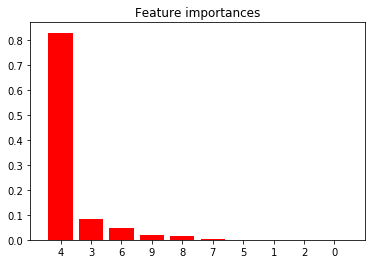

In [241]:
gbc_importances = gbc.feature_importances_
gbc_std = np.std([gbc.feature_importances_ for tree in gbc.estimators_], axis=0)
gbc_indices = np.argsort(gbc_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns.tolist()[gbc_indices[f]], gbc_importances[gbc_indices[f]]))

# Plot the feature importances of the gbc
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), gbc_importances[gbc_indices],
       color="r", yerr=gbc_std[gbc_indices], align="center")
plt.xticks(range(X_train.shape[1]), gbc_indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [188]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,random_state=0)
gbr.fit(X_train, y_train)
gbr_pred = (gbr.predict(X_test)>=0.5)*1
eval_metric(gbr_pred, y_test)

confusion matrix
[[43884  7080]
 [ 9473 75703]]


summary
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     50964
           1       0.91      0.89      0.90     85176

    accuracy                           0.88    136140
   macro avg       0.87      0.87      0.87    136140
weighted avg       0.88      0.88      0.88    136140



Feature ranking:
1. feature PA (0.826502)
2. feature RA (0.083537)
3. feature TN (0.050626)
4. feature N2V (0.018795)
5. feature TFIDF (0.016021)
6. feature AR (0.002302)
7. feature ND (0.001718)
8. feature JC (0.000223)
9. feature AA (0.000209)
10. feature CN (0.000067)


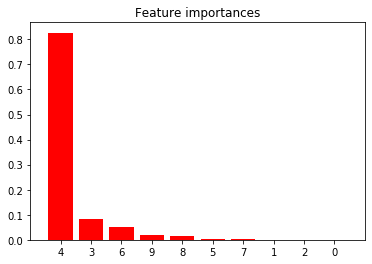

In [242]:
gbr_importances = gbr.feature_importances_
gbr_std = np.std([gbr.feature_importances_ for tree in gbr.estimators_], axis=0)
gbr_indices = np.argsort(gbr_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns.tolist()[gbr_indices[f]], gbr_importances[gbr_indices[f]]))

# Plot the feature importances of the gbr
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), gbr_importances[gbr_indices],
       color="r", yerr=gbr_std[gbr_indices], align="center")
plt.xticks(range(X_train.shape[1]), gbr_indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## 1.7. Majority Vote (XGB, GBC, GBR)


In [212]:
mv1 = pd.DataFrame({'xgb':xg_preds,'gbc':gbc_pred,'gbr':gbr_pred})

mv1_pred = list(map(int,round(mv1.sum(axis=1)/3).tolist()))
eval_metric(mv1_pred, y_test)

confusion matrix
[[43900  7064]
 [ 9451 75725]]


summary
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     50964
           1       0.91      0.89      0.90     85176

    accuracy                           0.88    136140
   macro avg       0.87      0.88      0.87    136140
weighted avg       0.88      0.88      0.88    136140



## 3.1. Parameter tuning 
We focus on three parameters namely n_estimators, max_features, max_depth

In [96]:
# random forest model 
rfc1 = RandomForestClassifier(n_estimators = 150, max_features = None)
rfc1.fit(X_train,y_train)
# predictions
rfc1_predict = rfc.predict(X_test)

eval_metric(rfc1_predict, y_test)

confusion matrix
[[43608  7356]
 [11086 74090]]


summary
              precision    recall  f1-score   support

           0       0.80      0.86      0.83     50964
           1       0.91      0.87      0.89     85176

    accuracy                           0.86    136140
   macro avg       0.85      0.86      0.86    136140
weighted avg       0.87      0.86      0.87    136140



In [219]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 250, num = 3)]
# number of features at every split
max_features = ['auto']

# max depth
max_depth = [int(x) for x in np.linspace(100, 250, num = 3)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=20, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.5min finished
{'n_estimators': 175, 'max_features': 'auto', 'max_depth': None}


In [222]:
# random forest model 
rfc_f = RandomForestClassifier(n_estimators = 175, max_features='auto')
rfc_f.fit(X_train,y_train)
# predictions
rfc_f_predict = rfc_f.predict(X_test)

eval_metric(rfc_f_predict, y_test)

confusion matrix
[[43031  7933]
 [ 9745 75431]]


summary
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     50964
           1       0.90      0.89      0.90     85176

    accuracy                           0.87    136140
   macro avg       0.86      0.86      0.86    136140
weighted avg       0.87      0.87      0.87    136140



# 4.Final prediction

## 4.1. Models 
### A. Random forest (0.89643)

In [99]:
# random forest model 
rfc_final = RandomForestClassifier()
rfc_final.fit(X_all,y_all)
# predictions
rfc_final_predict = rfc_final.predict(demand_df)

In [100]:
rfc_final_predict

array([1, 1, 0, ..., 0, 1, 0])

In [138]:
import csv

predictions = rfc_final_predict
zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
with open("rfc_predictions.csv","w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### B. KNN (0.88971)

In [139]:
# knn model
knn_final = KNeighborsClassifier(n_neighbors=2, n_jobs=-1, leaf_size=1, weights='distance')
knn_final.fit(X_all,y_all)
knn_final_pred = knn_final.predict(demand_df)

predictions = knn_final_pred
zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
with open("knn_predictions.csv","w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### C RF G=G+E_pred(0.89631)
Assuming we approximate the true graph by adding predicted edges.


In [106]:
# add predicted edges to file 
with open('testing.txt') as f:
     i = 0
     for line in f:
         line = line.split()
         if (predictions[i]==1): # add edge if predicted with an edge
             G.add_edge(line[0],line[1])
         i+=1

In [113]:
# list to store 
all_df_list = [all_df]
G_list = [pd.read_pickle('model_G_df_raw.pkl')['G'][0]]
demand_df_list = [demand_df]
COUNT = 1

rfc_final_list = [rfc_final]
rfc_final_predict_list = [rfc_final_predict]

In [114]:

# data used for final model 
all_df = pd.DataFrame(Data_dict(D))
all_df_list.append(all_df)
all_df.to_pickle('all'+str(COUNT)+'.pkl')

# final prediction training data 
demand_df = pd.DataFrame(Data_dict_test(D_testing))
demand_df_list.append(demand_df)
demand_df.to_pickle('final_pred'+str(COUNT)+'.pkl')

X_all = all_df.loc[:, all_df.columns != 'label']
y_all = all_df['label'].tolist()

COUNT += 1

In [115]:
# random forest model 
rfc_final = RandomForestClassifier()
rfc_final_list.append(rfc_final)
rfc_final.fit(X_all,y_all)
# predictions
rfc_final_predict = rfc_final.predict(demand_df)
rfc_final_predict_list.append(rfc_final_predict)

In [121]:
sum(rfc_final_predict_list[0] != rfc_final_predict)/len(rfc_final_predict)

0.024786249449096517

In [ ]:
predictions = rfc_final_predict
zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "rfc_predictions"+str(COUNT-1)+".csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### C. majority vote (0.90625)
- rfc_predictions.csv (0.89643)
- knn_predictions.csv (0.88971)
- xgb_predictions.csv (0.90018)

In [147]:
t2 = pd.read_csv("rfc_predictions.csv")
t3 = pd.read_csv("knn_predictions.csv")
t4 = pd.read_csv("xgb_predictions.csv")

In [131]:
sum(t1['predicted'] !=t2['predicted'])

2812

In [158]:
t_all = pd.DataFrame({'2':t2['predicted'].tolist(),'3':t3['predicted'].tolist(),'4':t4['predicted'].tolist()
})

In [179]:
predictions = list(map(int,round(t_all.sum(axis=1)/3).tolist()))

zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "ensemble_predictions.csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### D. GradientBoosting 
- GBC (0.90024)


In [189]:
gbc_final = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,random_state=0)
gbc_final.fit(X_all,y_all)
gbc_final_pred = gbc_final.predict(demand_df)

In [190]:
gbr_final = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,random_state=0)
gbr_final.fit(X_all, y_all)
gbr_final_pred = (gbr_final.predict(demand_df)>=0.5)*1


In [191]:
predictions = gbr_final_pred

zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "gbr_predictions.csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

In [192]:
predictions = gbc_final_pred

zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "gbc_predictions.csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### E. majority vote 1 (0.90423)
- rfc_predictions.csv (0.89643)
- knn_predictions.csv (0.88971)
- xgb_predictions.csv (0.90018)
- gbc_predictions.csv (0.90024)
- gbr_predictions.csv

In [193]:
t2 = pd.read_csv("rfc_predictions.csv")
t3 = pd.read_csv("knn_predictions.csv")
t4 = pd.read_csv("xgb_predictions.csv")
t5 = pd.read_csv("gbc_predictions.csv")
t6 = pd.read_csv("gbr_predictions.csv")


In [202]:
t_all1 = pd.DataFrame({'2':t2['predicted'].tolist(),'3':t3['predicted'].tolist(),'4':t4['predicted'].tolist(), '5':t5['predicted'], '6':t6['predicted']
})

In [199]:
t_list1 = [t2['predicted'].tolist(), t3['predicted'].tolist(), t4['predicted'].tolist(),t5['predicted'].tolist(),t6['predicted'].tolist()]
dif_mat = []
for i in range(len(t_list1)):
    temp = []
    for j in range(len(t_list1)):
        temp.append(sum(np.subtract(t_list1[i], t_list1[j])!=0)/len(t_list1[j]))
    dif_mat.append(temp)

dif_mat

[[0.0,
  0.07228735125605994,
  0.08645218157778757,
  0.026734244160423092,
  0.03307183781401499],
 [0.07228735125605994,
  0.0,
  0.08189510797708241,
  0.06892904363155575,
  0.06738651388276774],
 [0.08645218157778757,
  0.08189510797708241,
  0.0,
  0.07805200528867343,
  0.07215513442044953],
 [0.026734244160423092,
  0.06892904363155575,
  0.07805200528867343,
  0.0,
  0.013918025561921551],
 [0.03307183781401499,
  0.06738651388276774,
  0.07215513442044953,
  0.013918025561921551,
  0.0]]

The difference between each prediction of predictor, the dignal element is of course 0% (comparasion of self)

In [203]:
predictions = list(map(int,round(t_all1.sum(axis=1)/5).tolist()))

zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "ensemble1_predictions.csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

### F. Majority vote of (mv, mv1, best) 90.4%
- mv (90.4%)
- mv1 (90.6%)
- best (copy of prediction5 91.6%)

In [218]:
pred_best = np.load("Copy of prediction_5.npy")
Tfinal = pd.DataFrame({'best': pred_best, 'mv1': list(map(int,round(t_all1.sum(axis=1)/5).tolist())), 'mv': list(map(int,round(t_all.sum(axis=1)/3).tolist()))})
predictions = list(map(int,round(Tfinal.sum(axis=1)/3).tolist()))
zipp = zip(range(len(predictions)), predictions)
# Write the output in the format required by Kaggle
file_name = "ensembleBEST_predictions.csv"
with open(file_name,"w") as p:
    csv_out = csv.writer(p)
    csv_out.writerow(['id','predicted'])
    for row in zipp:
        csv_out.writerow(row) 

In practice, this method can have some problems, since the final prediction is even worse than each individel predictor